In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import save,load

# NLP stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

from gensim.models import Word2Vec
import gensim

# LSTM machine stuff etc
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import re
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [2]:
#SETTINGS

#DATASET
TRAIN_SIZE = 0.8

#TEXT CLEANING REGEX 
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 16
BATCH_SIZE = 1024

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
sentiment_cnt = Counter(df.sentiment)

sentiment_cnt

Counter({'positive': 25000, 'negative': 25000})

Preprocess Text

In [9]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [11]:
def preprocess(text):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    return " ".join(tokens)

In [12]:
%%time
df.review = df.review.apply(lambda x:preprocess(x))

Wall time: 1min 45s


Splitting Training and Testing Set

In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=123)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 40000
TEST size: 10000


In [14]:
df_train

,review,sentiment
2660,ok first may spoiler sinc know constitut give ...,negative
32815,came new port south expect surrog movi columbi...,negative
35141,1st watch 8 7 2004 3 10 dir brett thompson sil...,negative
19390,first post imdb unfortun warn other wast time ...,negative
34846,movi man like blow gas contain br br also love...,negative
...,...,...
7763,movi sooooooo good hilari mani joke watch movi...,positive
15377,nifti littl movi demonstr rock solid virtu tim...,positive
17730,one moment film laugh mel brook one high point...,positive
28030,fan troma cyberpunk genr mix littl blood shed ...,positive


Word2Vec Model

In [15]:
documents = [review.split() for review in df_train.review]

In [16]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [17]:
w2v_model.build_vocab(documents)

In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 1min 41s


(142750915, 158605408)

In [19]:
w2v_model.wv.most_similar("enjoy")

[('fun', 0.5499842166900635),
 ('entertain', 0.534699559211731),
 ('appreci', 0.5243308544158936),
 ('recommend', 0.5077123641967773),
 ('watch', 0.4603218138217926),
 ('disappoint', 0.4233514368534088),
 ('movi', 0.40351954102516174),
 ('worth', 0.39302074909210205),
 ('expect', 0.38596299290657043),
 ('fan', 0.3779257535934448)]

In [20]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.review)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 63400
Wall time: 3.64 s


In [21]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train. review), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.review), maxlen=SEQUENCE_LENGTH)

Wall time: 3.54 s


In [22]:
labels = df_train.sentiment.unique().tolist()
labels

['negative', 'positive']

In [23]:
encoder = LabelEncoder()
encoder.fit(df_train.sentiment.tolist())

y_train = encoder.transform(df_train.sentiment.tolist())
y_test = encoder.transform(df_test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (40000, 1)
y_test (10000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)

print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (40000, 300)
y_train (40000, 1)
x_test (10000, 300)
y_test (10000, 1)


In [25]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(63400, 300)


In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          19020000  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 64)           96064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 74, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 19,215,009
Trainable params: 195,009
Non-trainable params: 19,020,000
______________________________________

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [28]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [29]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/16
36/36 [==============================] - 100s 3s/step - loss: 0.4722 - accuracy: 0.7617 - val_loss: 0.3199 - val_accuracy: 0.8645
Epoch 2/16
36/36 [==============================] - 113s 3s/step - loss: 0.2981 - accuracy: 0.8743 - val_loss: 0.2986 - val_accuracy: 0.8763
Epoch 3/16
36/36 [==============================] - 126s 4s/step - loss: 0.2745 - accuracy: 0.8850 - val_loss: 0.2763 - val_accuracy: 0.8870
Epoch 4/16
36/36 [==============================] - 144s 4s/step - loss: 0.2516 - accuracy: 0.8971 - val_loss: 0.3140 - val_accuracy: 0.8792
Epoch 5/16
36/36 [==============================] - 120s 3s/step - loss: 0.2420 - accuracy: 0.9006 - val_loss: 0.2777 - val_accuracy: 0.8878
Epoch 6/16
36/36 [==============================] - 124s 3s/step - loss: 0.2217 - accuracy: 0.9093 - val_loss: 0.2723 - val_accuracy: 0.8888
Epoch 7/16
36/36 [==============================] - 132s 4s/step - loss: 0.2128 - accuracy: 0.9139 - val_loss: 0.2806 - val_accuracy: 0.8923
Epoch 8/16
36

In [30]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 10s 1s/step - loss: 0.2767 - accuracy: 0.9017

ACCURACY: 0.9017000198364258
LOSS: 0.2767311930656433
Wall time: 10.5 s


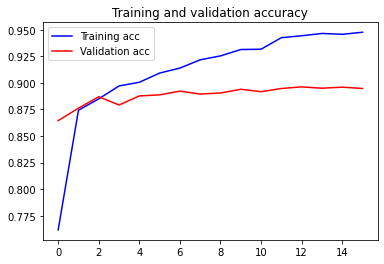

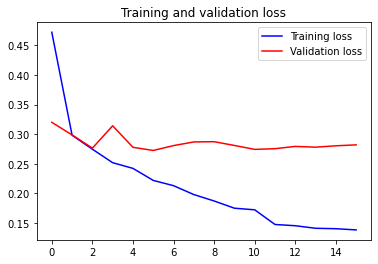

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [32]:
def decode_sentiment(score):
    return "negative" if score < 0.5 else "positive"

In [33]:
def predict(text):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    score = model.predict([x_test])[0]
    label = decode_sentiment(score)
    return {"label": label, "score": float(score)}

In [34]:
predict("This movie was good!")

{'label': 'positive', 'score': 0.5686603784561157}

In [35]:
predict("This movie was very bad. So boring!")

{'label': 'negative', 'score': 0.12787219882011414}

In [36]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [37]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.sentiment)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score) for score in scores]

2/2 [==============================] - 10s 2s/step
Wall time: 9.81 s


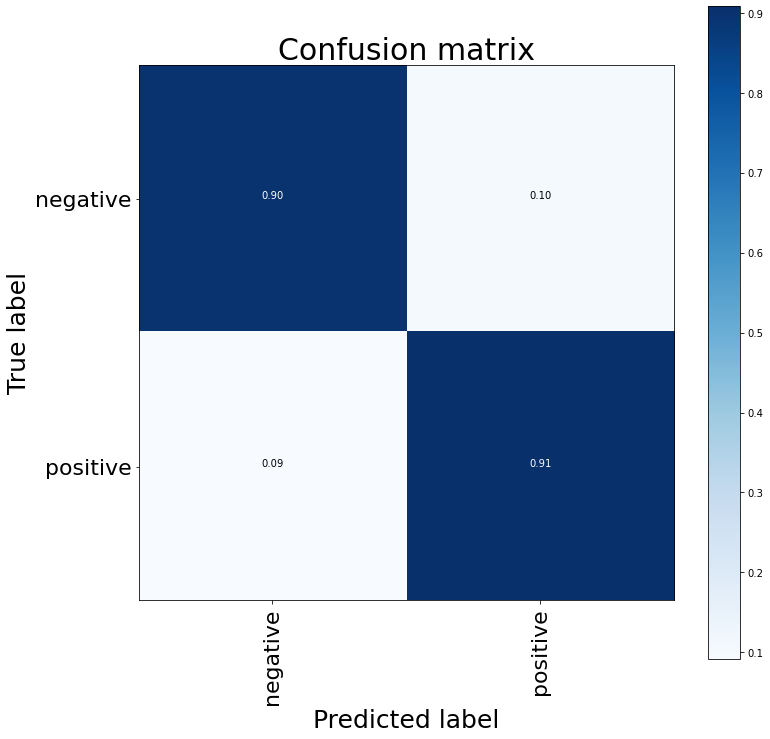

In [38]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.sentiment.unique(), title="Confusion matrix")
plt.show()

In [39]:
print(classification_report(y_test_1d, y_pred_1d))


              precision    recall  f1-score   support

    negative       0.91      0.90      0.90      4979
    positive       0.90      0.91      0.90      5021

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [40]:
accuracy_score(y_test_1d, y_pred_1d)


0.9017

In [41]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)